Final Project Kevin Shi

In [1]:
# Set up
import pandas as pd
import os
import re
import numpy as np
import torch
import torch.nn as nn
import keras
from collections import Counter
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from tqdm import tqdm
import medspacy
import re
from transformers import pipeline

In [277]:
!pip install scipy==1.10.1

   ---------------------------------------- 0.0/42.5 MB ? eta -:--:--
   ------ --------------------------------- 7.3/42.5 MB 45.4 MB/s eta 0:00:01
   ------- -------------------------------- 8.4/42.5 MB 32.5 MB/s eta 0:00:02
   ----------- ---------------------------- 12.6/42.5 MB 22.6 MB/s eta 0:00:02
   ---------------- ----------------------- 17.8/42.5 MB 23.0 MB/s eta 0:00:02
   -------------------- ------------------- 22.0/42.5 MB 22.5 MB/s eta 0:00:01
   ------------------------- -------------- 27.3/42.5 MB 22.4 MB/s eta 0:00:01
   --------------------------- ------------ 29.4/42.5 MB 21.4 MB/s eta 0:00:01
   ----------------------------------- ---- 37.7/42.5 MB 24.0 MB/s eta 0:00:01
   ---------------------------------------  42.5/42.5 MB 23.5 MB/s eta 0:00:01
   ---------------------------------------- 42.5/42.5 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scip

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.3.0 requires scipy>=1.13.0, but you have scipy 1.10.1 which is incompatible.


ImportError: cannot import name 'gaussian' from 'scipy.signal' (C:\Users\kevxs\anaconda3\lib\site-packages\scipy\signal\__init__.py)

In [2]:
import bambi as bmb
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Read in data
os.chdir("C:/Users/kevxs/OneDrive/Documents/WIP Research Stuff/Telehealth and Nephrology/Data and Analysis 2/5_31 data/")
df = pd.read_csv('Data Sci 223.csv', encoding='latin1')
top = df.head(10)
print(top)

   Unnamed: 0  PAT_ENC_CSN_ID  UCSF_MRN   APPT_DATE APPT_DTTM  \
0           1       195751622     11789  2023-08-25   00:00.0   
1           2       199339531     11789  2023-12-22   30:00.0   
2           3       202677779     11789  2024-06-07   30:00.0   
3           4       215898943     11789  2024-10-01   30:00.0   
4           5       202130465     20672  2024-02-13   30:00.0   
5           6       205359736     20672  2024-05-07   00:00.0   
6           7       214536274     20672  2024-08-06   30:00.0   
7           8       215614951     20672  2024-10-01   00:00.0   
8           9       120576326     24490  2020-01-22   30:00.0   
9          10       156323929     24490  2021-07-28   30:00.0   

    ENCOUNTER_DEPT ENCOUNTER_CATEGORY ENCOUNTER_TYPE ENCOUNTER_STATUS  \
0  NEPHROLOGY PARN       Office Visit    NEW PATIENT        Completed   
1  NEPHROLOGY PARN       Office Visit      FOLLOW UP        Completed   
2  NEPHROLOGY PARN       Office Visit      FOLLOW UP        Compl

In [271]:
def extract_combined_subjective_sections(note_text):
    if not isinstance(note_text, str):
        return None

    note_text = note_text.strip()

    # Start headers (case-insensitive)
    start_headers = [
        'SUBJECTIVE',
        'CHIEF COMPLAINT',
        'HISTORY OF PRESENT ILLNESS',
        'INTERIM HISTORY'
    ]

    stop_headers = [
        'Physical Exam',
        'Objective',
        'Impression',
        'Assessment',
        'Plan',
        'Review of Systems',
        'Social History',
        'Past Medical History',
        'Past Surgical History',
        'Past Medical/Surgical History',
        'Medications',
        'Allergies',
        'Allergies/Contraindications',
        'Family History'
    ]

    # Compile regex for start headers (case-insensitive), with optional colon and trailing spaces
    start_pattern = re.compile(
        r'(?i)\b(' + '|'.join(re.escape(h) for h in start_headers) + r')\b\s*:?',
    )

    # Compile regex for stop headers - exact phrase, but match only Title Case or UPPERCASE
    # Match the whole stop header phrase, ignoring trailing punctuation, but don't care about what follows on the line
    stop_pattern = re.compile(
        r'\b(' + '|'.join(re.escape(h) for h in stop_headers) + r')\b',
    )

    # Find all start header matches (start index + text)
    start_matches = [(m.start(), m.group()) for m in start_pattern.finditer(note_text)]

    # Find all stop header matches (start index + text)
    stop_matches_all = [(m.start(), m.group()) for m in stop_pattern.finditer(note_text)]

    # Filter stop headers by case: keep only those that are Title Case or UPPERCASE exactly
    stop_matches = [(pos, txt) for pos, txt in stop_matches_all if txt.istitle() or txt.isupper()]

    # Sort stop matches by position (should already be sorted, but let's be sure)
    stop_matches = sorted(stop_matches, key=lambda x: x[0])

    section_ranges = []
    for start_pos, _ in start_matches:
        # Find the closest stop header start position that comes after this start header
        stops_after = [pos for pos, txt in stop_matches if pos > start_pos]
        end_pos = min(stops_after) if stops_after else len(note_text)
        section_ranges.append((start_pos, end_pos))

    # Merge overlapping/nested ranges
    merged_ranges = []
    for start, end in sorted(section_ranges):
        if merged_ranges and start >= merged_ranges[-1][0] and end <= merged_ranges[-1][1]:
            continue
        merged_ranges.append((start, end))

    # Extract sections based on these ranges
    sections = [note_text[start:end].strip() for start, end in merged_ranges]

    return '\n\n'.join(sections) if sections else None


In [272]:
top['subjective'] = top['ENCOUNTER_NOTE'].apply(extract_combined_subjective_sections)
print(top['subjective'])

0    Chief Complaint   Patient presents with    New...
1    Interim History:  Anne was last seen on 08/25/...
2    Interim History:  Anne was last seen on 12/22/...
3    Interim History:  Anne was last seen on 06/07/...
4    Subjective    Philip L Judson is a 55 y.o. man...
5    Subjective    Philip L Judson is a 55 y.o. mal...
6    Subjective    Philip L Judson is a 56 y.o. mal...
7    Subjective    Philip L Judson is a 56 y.o. mal...
8    HISTORY OF PRESENT ILLNESS  Interval Hx  Accom...
9    HISTORY OF PRESENT ILLNESS  Interval Hx  Chest...
Name: subjective, dtype: object


In [273]:
print(top['subjective'].iloc[9])

HISTORY OF PRESENT ILLNESS  Interval Hx  Chest pain evaluation, bigeminy and atrial fibrillation, elevated BP to 150-195 systolically, John Muir Concord June 1, 2021, added hydralazine for BP and apixaban/aspirin for afib. Bumex 1 mg daily reduced to 0.5 mg daily, stopped earlier this week after his SCr spike to 2.45 mg/dL last week.  Hydralazine 110-140, reduced dose from 25 mg TID to BID, 130s to 160s.   Heart rate 50s to 80s, 30s to 60s (may be spuriously low due to bigeminy), currently on holter monitor. Dr. Crawford not available due to COVID, now seeing cardiologist Dr. Michael Tsang at Sutter, echo WNL by report.  Medium edema but no pitting per family, compression stockings. Weight 141 pounds currently, 145 peak, 138 minimum.  Feels tired due to lack of sleep, nocturia, naps during the daytime, going to PT, no orthopnea/PND (uses 2 pillows at night).    No recent illnesses, ED visits, hospitalizations.  No urinary or uremic symptoms, no hematuria or dysuria.    July 2021 labs s

In [274]:
sampled_df = df.sample(n=1000, random_state=42) # now do a random sample of 1000
sampled_df['subjective'] = sampled_df['ENCOUNTER_NOTE'].apply(extract_combined_subjective_sections)
print(sampled_df['subjective'].iloc[0])

Chief Complaint: Follow ip of CKD  Interpreter: available via telehealth    HISTORY OF PRESENT ILLNESS  Interval Hx  Occasional joint pain in neck/shoulders. No skin or hair issues. Feels well - no specific complaints. No urinary or uremic symptoms. No recent hospitalizations/ED visits or illnesses. Recent labs show stable kidney function. Slightly higher urine protein than before, urine albumin 400+ mg/g creatinine  Blood pressures checked at home every few weeks. SBP 120s/70s. Currently MMF 500 mg daily, prednisone 5 mg daily, lisinopril 5 mg daily,     Mammogram April 2021 at ZSFG - negative R, benign L breast. Covid vaccines in April and May 2021


In [275]:
from transformers import pipeline

sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,
    max_length=512
)

# Define a safe chunking function
def split_into_chunks(text, tokenizer, max_tokens=510):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i+max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

import textwrap

def analyze_long_text(text, classifier, max_length=510):
    if not isinstance(text, str) or text.strip() == "":
        return None

    # Approximate chunking: split into ~max_length word chunks
    words = text.split()
    chunks = [' '.join(words[i:i+max_length]) for i in range(0, len(words), max_length)]

    # Run classifier with truncation (safe for each chunk)
    results = classifier(chunks, truncation=True)

    # Collect scores by label
    label_scores = {}
    for result in results:
        label = result['label']
        score = result['score']
        if label not in label_scores:
            label_scores[label] = []
        label_scores[label].append(score)

    # Compute average scores
    avg_scores = {label: sum(scores)/len(scores) for label, scores in label_scores.items()}

    best_label = max(avg_scores, key=avg_scores.get)
    return {'label': best_label, 'score': avg_scores[best_label]}


Device set to use cpu


In [217]:
sampled_df['sentiment'] = sampled_df['subjective'].apply(
    lambda x: analyze_long_text(str(x), sentiment_classifier) if pd.notnull(x) else None
)

In [248]:
sampled_df['sentiment_full'] = sampled_df['ENCOUNTER_NOTE'].apply(
    lambda x: analyze_long_text(str(x), sentiment_classifier) if pd.notnull(x) else None
)

In [249]:
num_missing = sampled_df['subjective'].isna().sum()
print(f"Number of missing (None or NaN) values: {num_missing}")

Number of missing (None or NaN) values: 135


In [250]:
print(sampled_df.head())

       Unnamed: 0  PAT_ENC_CSN_ID  UCSF_MRN   APPT_DATE APPT_DTTM  \
26830       26831       159810594  60634882  2022-03-09   00:00.0   
17497       17498       195776117  47468043  2023-10-03   30:00.0   
277           278       168069062    506478  2022-04-29   30:00.0   
13735       13736       188887381  42892874  2023-04-06   20:00.0   
32674       32675       153815317  70697882  2021-05-20   00:00.0   

        ENCOUNTER_DEPT ENCOUNTER_CATEGORY ENCOUNTER_TYPE ENCOUNTER_STATUS  \
26830  NEPHROLOGY PARN       Telemedicine        IVV FUP        Completed   
17497  NEPHROLOGY PARN       Telemedicine        IVV FUP        Completed   
277    NEPHROLOGY PARN       Office Visit      FOLLOW UP        Completed   
13735  NEPHROLOGY PARN       Telemedicine        IVV NEW        Completed   
32674  NEPHROLOGY PARN       Office Visit    NEW PATIENT        Completed   

                           PROV_NAME  ...  \
26830            CHO, KERRY CHANGSIG  ...   
17497  BREEGGEMANN, MATTHEW CLAR

In [220]:
print(sampled_df['subjective'].iloc[0])

Chief Complaint: Follow ip of CKD  Interpreter: available via telehealth    HISTORY OF PRESENT ILLNESS  Interval Hx  Occasional joint pain in neck/shoulders. No skin or hair issues. Feels well - no specific complaints. No urinary or uremic symptoms. No recent hospitalizations/ED visits or illnesses. Recent labs show stable kidney function. Slightly higher urine protein than before, urine albumin 400+ mg/g creatinine  Blood pressures checked at home every few weeks. SBP 120s/70s. Currently MMF 500 mg daily, prednisone 5 mg daily, lisinopril 5 mg daily,     Mammogram April 2021 at ZSFG - negative R, benign L breast. Covid vaccines in April and May 2021


In [221]:
print(sentiment_classifier("Chief Complaint: Follow ip of CKD  Interpreter: available via telehealth    HISTORY OF PRESENT ILLNESS  Interval Hx  Occasional joint pain in neck/shoulders. No skin or hair issues. Feels well - no specific complaints. No urinary or uremic symptoms. No recent hospitalizations/ED visits or illnesses. Recent labs show stable kidney function. Slightly higher urine protein than before, urine albumin 400+ mg/g creatinine  Blood pressures checked at home every few weeks. SBP 120s/70s. Currently MMF 500 mg daily, prednisone 5 mg daily, lisinopril 5 mg daily,     Mammogram April 2021 at ZSFG - negative R, benign L breast. Covid vaccines in April and May 2021"))

[{'label': 'NEGATIVE', 'score': 0.9953035116195679}]


In [222]:
print(sampled_df['sentiment'].iloc[0])

{'label': 'NEGATIVE', 'score': 0.9953035116195679}


In [252]:
sampled_df['sentiment_full_label'] = sampled_df['sentiment_full'].apply(
    lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None
)

# View distribution
label_distribution = sampled_df['sentiment_full_label'].value_counts(dropna=False)
print(label_distribution)

sentiment_full_label
NEGATIVE    988
POSITIVE      8
None          4
Name: count, dtype: int64


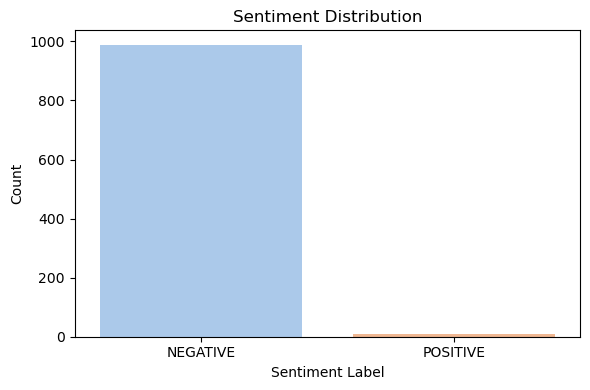

In [253]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=sampled_df, x='sentiment_full_label', palette='pastel')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

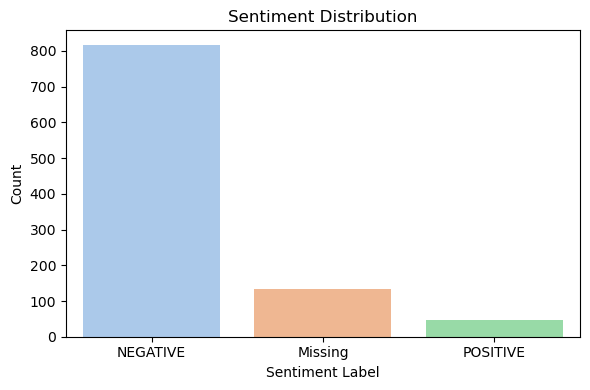

In [254]:
# Prepare the sentiment label column
sampled_df['sentiment_label'] = sampled_df['sentiment'].apply(
    lambda x: x['label'] if isinstance(x, dict) and 'label' in x else 'Missing'
)

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=sampled_df, x='sentiment_label', palette='pastel')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [227]:
total_avg = sampled_df['med_changes_count'].mean()
print("Total average of med_changes:", total_avg)

Total average of med_changes: 0.975


In [228]:
# Filter out missing or other labels if needed
positive_avg = sampled_df[sampled_df['sentiment_label'] == 'POSITIVE']['med_changes_count'].mean()
negative_avg = sampled_df[sampled_df['sentiment_label'] == 'NEGATIVE']['med_changes_count'].mean()

print("Average med_changes for POSITIVE sentiment:", positive_avg)
print("Average med_changes for NEGATIVE sentiment:", negative_avg)

Average med_changes for POSITIVE sentiment: 0.9375
Average med_changes for NEGATIVE sentiment: 1.0


In [255]:
sampled_df['transformer_label'] = sampled_df['sentiment'].apply(
    lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None
)
comparison_table = pd.crosstab(sampled_df['Telehealth'], sampled_df['transformer_label'])

print(comparison_table)

transformer_label  NEGATIVE  POSITIVE
Telehealth                           
In-person               247        14
Telehealth Video        570        34


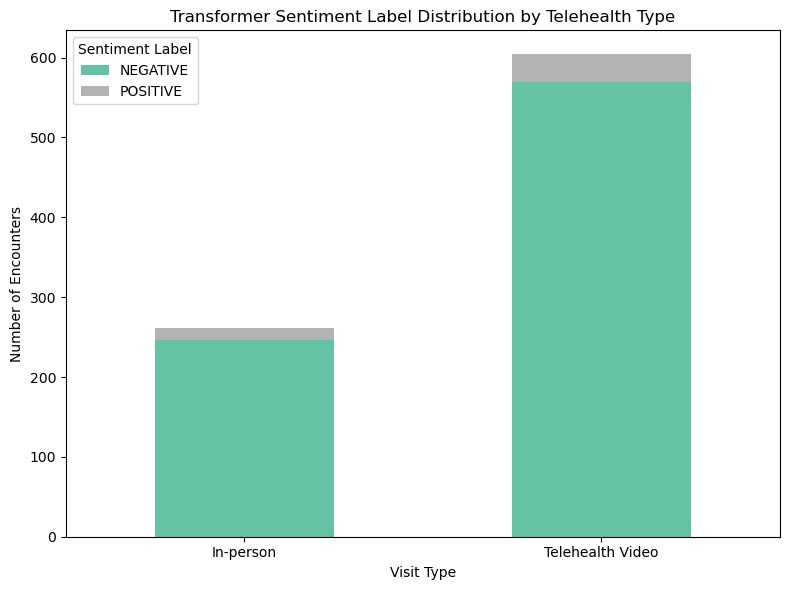

In [257]:
# Create stacked bar chart
comparison_table.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')

# Titles and labels
plt.title('Transformer Sentiment Label Distribution by Telehealth Type')
plt.xlabel('Visit Type')
plt.ylabel('Number of Encounters')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Label')

plt.tight_layout()
plt.show()

In [229]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kevxs\AppData\Roaming\nltk_data...


True

In [233]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the analyzer
vader = SentimentIntensityAnalyzer()

# Example
text = "Chief Complaint: Follow ip of CKD  Interpreter: available via telehealth    HISTORY OF PRESENT ILLNESS  Interval Hx  Occasional joint pain in neck/shoulders. No skin or hair issues. Feels well - no specific complaints. No urinary or uremic symptoms. No recent hospitalizations/ED visits or illnesses. Recent labs show stable kidney function. Slightly higher urine protein than before, urine albumin 400+ mg/g creatinine  Blood pressures checked at home every few weeks. SBP 120s/70s. Currently MMF 500 mg daily, prednisone 5 mg daily, lisinopril 5 mg daily,     Mammogram April 2021 at ZSFG - negative R, benign L breast. Covid vaccines in April and May 2021."
scores = vader.polarity_scores(text)
print(scores)

{'neg': 0.25, 'neu': 0.683, 'pos': 0.067, 'compound': -0.9667}


In [231]:
def get_vader_sentiment(text):
    if pd.isnull(text):
        return None
    return vader.polarity_scores(str(text))  # ensure string input

# Add sentiment scores
sampled_df['vader_scores'] = sampled_df['subjective'].apply(get_vader_sentiment)

# If you want just the compound score (overall sentiment)
sampled_df['vader_compound'] = sampled_df['vader_scores'].apply(lambda x: x['compound'] if x else None)

In [232]:
print(sampled_df['vader_compound'].head())

26830   -0.9667
17497   -0.9410
277         NaN
13735   -0.9201
32674   -0.9839
Name: vader_compound, dtype: float64


In [235]:
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return "POSITIVE"
    elif compound_score <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

sampled_df['vader_label'] = sampled_df['vader_compound'].apply(classify_sentiment)


In [236]:
sampled_df['transformer_label'] = sampled_df['sentiment'].apply(
    lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None
)
# Create a crosstab of VADER vs Transformer sentiment labels
comparison_table = pd.crosstab(sampled_df['vader_label'], sampled_df['transformer_label'])

print(comparison_table)

transformer_label  NEGATIVE  POSITIVE
vader_label                          
NEGATIVE                722        38
NEUTRAL                   9         3
POSITIVE                 86         7


In [237]:
# Compare labels directly
sampled_df['sentiment_agreement'] = sampled_df['vader_label'] == sampled_df['transformer_label']

# Show agreement rate
agreement_rate = sampled_df['sentiment_agreement'].mean()
print(f"Agreement rate: {agreement_rate:.2%}")

Agreement rate: 72.90%


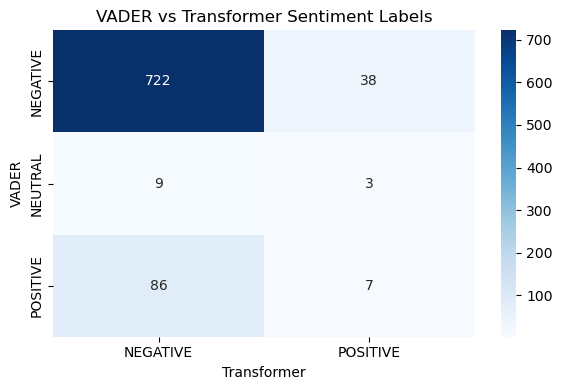

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(comparison_table, annot=True, fmt='d', cmap='Blues')
plt.title('VADER vs Transformer Sentiment Labels')
plt.ylabel('VADER')
plt.xlabel('Transformer')
plt.tight_layout()
plt.show()

In [239]:
# Get transformer label and score
sampled_df['transformer_label'] = sampled_df['sentiment'].apply(
    lambda x: x['label'] if isinstance(x, dict) else None
)
sampled_df['transformer_score'] = sampled_df['sentiment'].apply(
    lambda x: x['score'] if isinstance(x, dict) else None
)


In [240]:
# Define mask for extreme disagreements
extreme_disagreement_mask = (
    ((sampled_df['vader_label'] == 'POSITIVE') & (sampled_df['transformer_label'] == 'NEGATIVE')) |
    ((sampled_df['vader_label'] == 'NEGATIVE') & (sampled_df['transformer_label'] == 'POSITIVE'))
)

# Optional: add score threshold to focus on confident classifications
confident_disagreement = sampled_df[extreme_disagreement_mask].copy()
confident_disagreement = confident_disagreement[
    confident_disagreement['transformer_score'] >= 0.90
]

In [241]:
# Sort by descending confidence
confident_disagreement = confident_disagreement.sort_values(by='transformer_score', ascending=False)

# Show top few cases
confident_disagreement[['subjective', 'vader_label', 'transformer_label', 'transformer_score']].head(10)

,subjective,vader_label,transformer_label,transformer_score
18223,Subjective: REASON FOR VISIT/CC: Follow-up a...,POSITIVE,NEGATIVE,0.998517
8122,Subjective Danielle Chambers is a 33 y.o. f...,POSITIVE,NEGATIVE,0.998202
3835,Subjective: REASON FOR VISIT/CC: Follow-up (...,POSITIVE,NEGATIVE,0.997823
2772,Chief Complaint: CKD Chief Complaint ...,POSITIVE,NEGATIVE,0.997763
16181,chief complaint of lupus and lupus nephritis. ...,POSITIVE,NEGATIVE,0.997685
12564,Subjective John Robert Levitt is a 79 y.o. ...,POSITIVE,NEGATIVE,0.997671
16185,chief complaint of lupus and lupus nephritis. ...,POSITIVE,NEGATIVE,0.997650
22225,chief complaint of immune complex glomerulonep...,POSITIVE,NEGATIVE,0.997279
6237,Chief Complaint: New patient visit for CKD and...,POSITIVE,NEGATIVE,0.997272
30496,Subjective: REASON FOR VISIT/CC: Follow-up ...,POSITIVE,NEGATIVE,0.997169


In [242]:
print(confident_disagreement['subjective'].iloc[0])

Subjective:   REASON FOR VISIT/CC: Follow-up and Chronic Kidney Disease       INTERVAL HISTORY FROM LAST VISIT:   Patient last seen 4.30.21.  Since last visit, patient reports continued dizziness.  Notes worsened after taking dose of verapamil 100mg and losartan 25mg PM doses.  In the past, removed the PM dose of losartan and she becomes hypertensive.  Otherwise, repeat  Mercury 24 hour level negative (unclear why serum was positive but now downtrending, original work up started with PMD).     Patient notes work changing insurance.  Switching care to San Carlos nephrologist- Dr. Jenny Lee.       Current


In [243]:
print(confident_disagreement['subjective'].iloc[1])

Subjective    Danielle Chambers is a 33 y.o. female who presents with the following:    Chief Complaint              Hypertension, unspecified type     Follow-up             I performed this evaluation using real-time telehealth tools, including a live video Zoom connection between my location and the patient's location. Prior to initiating, the patient consented to perform this evaluation using telehealth tools.     History of Present Illness   Danielle Chambers is a 33 y.o.. female with a past medical history significant for lupus and lupus nephritis who presented in Feb 2016 to reestablish care at UCSF.      The patient reports that she was diagnosed with lupus at the age of 4, and was treated primarily with prednisone.  Reviewing the records that are available to me, the patient does not appear to have been on other immunosuppressants.  She received a kidney biopsy in 1996 which showed an immune complex GN with tubuloreticular inclusions, subepithelial and subendothelial deposits a

In [244]:
print(confident_disagreement['subjective'].iloc[2])

Subjective:   REASON FOR VISIT/CC: Follow-up (CKD (chronic kidney disease), stage III (HCC))    History of recurrent AKI episodes concurrent with hypotension that resolves with increased hydration.     3/2019.  slight increase in weight since last visit. (previously able to intentionally lose ~20lbs of weight with carbohydrate avoidance since 2017)      INTERVAL HISTORY:   Last seen in renal clinic 9/2019  Trying to stay as hydrated as possible  Reports missing medications on occasion.     Complaining of daytime somnolence and poor sleep onset with seroquel. Stating that he functions better without seroquel    Because he takes all of his medications at once (at bedtime), he misses his medications such as lisinopril because he wishes to skip his seroquel dose Prescribed lisinopril 10mg daily. Does not regularly check his BP at home.     Now back to work at a church, parttime in the office, states it is low stress and a positive sign in his life. But he is lo longer under care at LPPI.  

In [245]:
vader_counts = pd.crosstab(sampled_df['Telehealth'], sampled_df['vader_label'])
transformer_counts = pd.crosstab(sampled_df['Telehealth'], sampled_df['transformer_label'])

print("VADER Label Counts by Telehealth Type:")
print(vader_counts)

print("\nTransformer Label Counts by Telehealth Type:")
print(transformer_counts)

VADER Label Counts by Telehealth Type:
vader_label       NEGATIVE  NEUTRAL  POSITIVE
Telehealth                                   
In-person              232       79        25
Telehealth Video       528       68        68

Transformer Label Counts by Telehealth Type:
transformer_label  NEGATIVE  POSITIVE
Telehealth                           
In-person               247        14
Telehealth Video        570        34


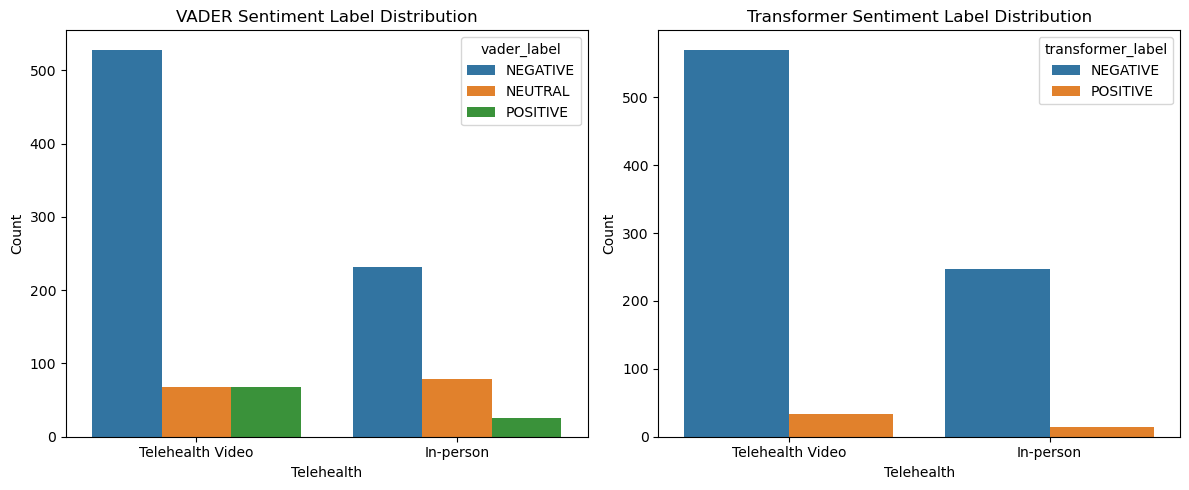

In [259]:
# Melt for plotting
vader_melted = sampled_df[['Telehealth', 'vader_label']].dropna()
transformer_melted = sampled_df[['Telehealth', 'transformer_label']].dropna()

plt.figure(figsize=(12, 5))

# VADER
plt.subplot(1, 2, 1)
sns.countplot(data=vader_melted, x='Telehealth', hue='vader_label')
plt.title("VADER Sentiment Label Distribution")
plt.ylabel("Count")

# Transformer
plt.subplot(1, 2, 2)
sns.countplot(data=transformer_melted, x='Telehealth', hue='transformer_label')
plt.title("Transformer Sentiment Label Distribution")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [260]:
conditions = [
    (sampled_df['vader_label'] == 'NEGATIVE') & (sampled_df['transformer_label'] == 'NEGATIVE'),
    (sampled_df['vader_label'] == 'POSITIVE') & (sampled_df['transformer_label'] == 'POSITIVE')
]

choices = ['NEGATIVE', 'POSITIVE']

# Default is 'UNCLEAR' when the labels disagree
sampled_df['combined_label'] = np.select(conditions, choices, default='UNCLEAR')

In [263]:
print(sampled_df['combined_label'].value_counts(dropna=False))

combined_label
NEGATIVE    722
UNCLEAR     271
POSITIVE      7
Name: count, dtype: int64


In [265]:
combined_counts = pd.crosstab(sampled_df['Telehealth'], sampled_df['combined_label'])
print(combined_counts)

combined_label    NEGATIVE  POSITIVE  UNCLEAR
Telehealth                                   
In-person              220         1      115
Telehealth Video       502         6      156


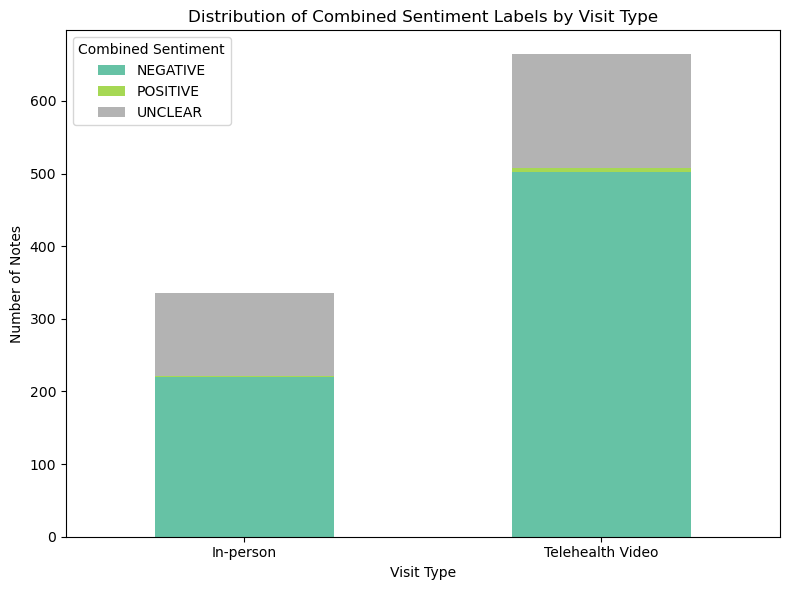

In [266]:
combined_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8, 6))

plt.title('Distribution of Combined Sentiment Labels by Visit Type')
plt.xlabel('Visit Type')
plt.ylabel('Number of Notes')
plt.legend(title='Combined Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [267]:
from scipy.stats import chi2_contingency

# Create the contingency table
contingency_table = pd.crosstab(sampled_df['Telehealth'], sampled_df['combined_label'])

# Run Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("\nExpected frequencies:\n", expected)

Chi-square statistic: 13.821384782745387
Degrees of freedom: 2
P-value: 0.0009970671967042435

Expected frequencies:
 [[242.592   2.352  91.056]
 [479.408   4.648 179.944]]


In [268]:
from scipy.stats import fisher_exact

# Collapse categories into POSITIVE vs NOT POSITIVE
sampled_df['is_positive'] = sampled_df['combined_label'] == 'POSITIVE'

# Create 2x2 table: rows = Telehealth type, columns = POSITIVE vs NOT POSITIVE
table_2x2 = pd.crosstab(sampled_df['Telehealth'], sampled_df['is_positive'])

# Run Fisher's Exact Test
oddsratio, p_value = fisher_exact(table_2x2)

print("2x2 contingency table:\n", table_2x2)
print("Fisher's Exact Test p-value:", p_value)

2x2 contingency table:
 is_positive       False  True 
Telehealth                    
In-person           335      1
Telehealth Video    658      6
Fisher's Exact Test p-value: 0.43420897482832976


In [4]:
model = bmb.Model(
    "med_changes_count ~ Telehealth + SEX_ASSIGNED_AT_BIRTH + AGE_AT_ENCOUNTER_s + "
    "RACE_ETHNICITY2 + New_Old + Time_since_last_visit_s + meds_count_s + "
    "egfr_s + PMHX_DM + PMHX_HTN + "
    "(1 + Telehealth | UCSF_MRN) + (1 | ENCOUNTER_NOTE_AUTHOR)",
    df,
    family="negativebinomial"
)

results = model.fit(draws=1000, chains=4)
az.summary(results)

ValueError: 'data' contains 21820 incomplete rows.

In [5]:
df[[
    "med_changes_count", "Telehealth", "SEX_ASSIGNED_AT_BIRTH", "AGE_AT_ENCOUNTER_s",
    "RACE_ETHNICITY2", "New_Old", "Time_since_last_visit_s", "meds_count_s",
    "egfr_s", "PMHX_DM", "PMHX_HTN", "UCSF_MRN", "ENCOUNTER_NOTE_AUTHOR"
]].isnull().sum()

med_changes_count              0
Telehealth                     0
SEX_ASSIGNED_AT_BIRTH          0
AGE_AT_ENCOUNTER_s             0
RACE_ETHNICITY2                0
New_Old                        0
Time_since_last_visit_s        0
meds_count_s                   0
egfr_s                     21800
PMHX_DM                        0
PMHX_HTN                       0
UCSF_MRN                       0
ENCOUNTER_NOTE_AUTHOR         64
dtype: int64

In [6]:
model_df = df.dropna(subset=[
    "med_changes_count", "Telehealth", "SEX_ASSIGNED_AT_BIRTH", "AGE_AT_ENCOUNTER_s",
    "RACE_ETHNICITY2", "New_Old", "Time_since_last_visit_s", "meds_count_s",
    "egfr_s", "PMHX_DM", "PMHX_HTN", "UCSF_MRN", "ENCOUNTER_NOTE_AUTHOR"
])

In [ ]:
model = bmb.Model(
    "med_changes_count ~ Telehealth + SEX_ASSIGNED_AT_BIRTH + AGE_AT_ENCOUNTER_s + "
    "RACE_ETHNICITY2 + New_Old + Time_since_last_visit_s + meds_count_s + "
    "egfr_s + PMHX_DM + PMHX_HTN + "
    "(1 + Telehealth | UCSF_MRN) + (1 | ENCOUNTER_NOTE_AUTHOR)",
    model_df,
    family="negativebinomial"
)

results = model.fit(draws=1000, chains=4)
az.summary(results)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [med_changes_count_alpha, Intercept, Telehealth, SEX_ASSIGNED_AT_BIRTH, AGE_AT_ENCOUNTER_s, RACE_ETHNICITY2, New_Old, Time_since_last_visit_s, meds_count_s, egfr_s, PMHX_DM, PMHX_HTN, 1|UCSF_MRN_sigma, 1|UCSF_MRN_offset, Telehealth|UCSF_MRN_sigma, Telehealth|UCSF_MRN_offset, 1|ENCOUNTER_NOTE_AUTHOR_sigma, 1|ENCOUNTER_NOTE_AUTHOR_offset]


In [3]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()
ro.globalenv["main"] = df  # assuming df is already cleaned

ro.r("""
library(glmmTMB)
nb_model_hierarchical <- glmmTMB(
  med_changes_count ~ Telehealth + SEX_ASSIGNED_AT_BIRTH + 
    AGE_AT_ENCOUNTER_s + RACE_ETHNICITY2 + New_Old + 
    Time_since_last_visit_s + meds_count_s + egfr_s + PMHX_DM + PMHX_HTN +
    (1 + Telehealth | UCSF_MRN) +
    (1 | ENCOUNTER_NOTE_AUTHOR),
  data = main,
  family = nbinom2
)
summary(nb_model_hierarchical)
""")


CalledProcessError: Command '('C:\\Program Files\\R\\R-4.4.3\\bin\\x64\\R', 'CMD', 'config', '--ldflags')' returned non-zero exit status 1.

In [2]:
!pip install rpy2